# How to train your own word vector embeddings

Many tasks require embeddings or domain-specific vocabulary that pre-trained models based on a generic corpus may not represent well or at all. Standard word2vec models are not able to assign vectors to out-of-vocabulary words and instead use a default vector that reduces their predictive value.

E.g., when working with industry-specific documents, the vocabulary or its usage may change over time as new technologies or products emerge. As a result, the embeddings need to evolve as well. In addition, corporate earnings releases use nuanced language not fully reflected in Glove vectors pre-trained on Wikipedia articles.

In this notebook we illustrate the more performant gensim adaptation of the code provided by the word2vec authors. 

To illustrate the word2vec network architecture, we use the Financial News data that we first introduced in chapter 14 on Topic Modeling. 

## Imports

In [104]:
%matplotlib inline 
import warnings
from time import time
from collections import Counter
from pathlib import Path
import pandas as pd
import numpy as np
from numpy.linalg import norm
from scipy.spatial.distance import cdist, cosine

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

from gensim.models import Word2Vec, KeyedVectors
from gensim.models.word2vec import LineSentence
from sklearn.decomposition import IncrementalPCA

### Settings

In [2]:
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
pd.set_option('float_format', '{:,.2f}'.format)
np.random.seed(42)

### Paths

In [3]:
news_path = Path('data', 'fin_news')
data_path = news_path / 'data'
analogy_path = Path('data', 'analogies', 'analogies-en.txt')

In [4]:
def format_time(t):
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:02.0f}:{m:02.0f}:{s:02.0f}'

## Model Configuration

In [5]:
gensim_path = news_path / 'gensim'
if not gensim_path.exists():
    gensim_path.mkdir(parents=True, exist_ok=True)

In [6]:
NGRAMS = 3           # Longest ngram in text
MIN_FREQ = 100
WINDOW_SIZE = 5
EMBEDDING_SIZE = 300
NEGATIVE_SAMPLES = 20
EPOCHS = 1

In [7]:
FILE_NAME = f'articles_{NGRAMS}_grams.txt'

## Sentence Generator

In [8]:
sentence_path = data_path / FILE_NAME
sentences = LineSentence(str(sentence_path))

## Train word2vec Model

In [9]:
start = time()
model = Word2Vec(sentences, 
                 sg=1, # set to 1 for skipgram; CBOW otherwise
                 size=EMBEDDING_SIZE, 
                 window=WINDOW_SIZE,
                 min_count=MIN_FREQ, 
                 negative=NEGATIVE_SAMPLES, 
                 workers=8,
                 iter=EPOCHS, 
                 alpha=0.05)

# persist model
model.save(str(gensim_path / 'word2vec.model'))

# persist word vectors
model.wv.save(str(gensim_path / 'word_vectors.bin'))
print('Duration:', format_time(time() - start))

Duration: 00:02:20


## Evaluate results

In [73]:
cat_dict = {'capital-common-countries':'Capitals',
            'capital-world':'Capitals RoW',
            'city-in-state':'City-State',
            'currency':'Currency',
            'family':'Famliy',
            'gram1-adjective-to-adverb':'Adj-Adverb',
            'gram2-opposite':'Opposite',
            'gram3-comparative':'Comparative',
            'gram4-superlative':'Superlative',
            'gram5-present-participle':'Pres. Part.',
            'gram6-nationality-adjective':'Nationality',
            'gram7-past-tense':'Past Tense',
            'gram8-plural':'Plural',
            'gram9-plural-verbs':'Plural Verbs',
            'total':'Total'}

In [10]:
def accuracy_by_category(acc, detail=True):
    results = [[c['section'], len(c['correct']), len(c['incorrect'])] for c in acc]
    results = pd.DataFrame(results, columns=['category', 'correct', 'incorrect'])
    results['average'] = results.correct.div(results[['correct', 'incorrect']].sum(1))
    if detail:
        print(results.sort_values('average', ascending=False))
    return results.loc[results.category=='total', ['correct', 'incorrect', 'average']].squeeze().tolist()

In [75]:
# gensim computes accuracy based on source text files
detailed_accuracy = model.wv.accuracy(analogy_path.as_posix(), case_insensitive=True)

In [76]:
# get accuracy per category
summary = accuracy_by_category(detailed_accuracy)
print('Base Accuracy: Correct {:,.0f} | Wrong {:,.0f} | Avg {:,.2%}\n'.format(*summary))

                       category  correct  incorrect  average
0      capital-common-countries      339         81     0.81
1                 capital-world      902        288     0.76
10  gram6-nationality-adjective      775        281     0.73
14                        total     3514       5066     0.41
7             gram3-comparative      305        565     0.35
2                 city-in-state      423        933     0.31
11             gram7-past-tense      342        780     0.30
4                        family       33         77     0.30
12                 gram8-plural       76        230     0.25
8             gram4-superlative       67        205     0.25
3                      currency       25        103     0.20
9      gram5-present-participle      111        489     0.18
13           gram9-plural-verbs       63        443     0.12
5     gram1-adjective-to-adverb       39        423     0.08
6                gram2-opposite       14        168     0.08
Base Accuracy: Correct 3

In [13]:
most_sim = model.wv.most_similar(positive=['woman', 'king'], negative=['man'], topn=20)
pd.DataFrame(most_sim, columns=['token', 'similarity'])

,token,similarity
0,meghan,0.44
1,alfred,0.44
2,kay,0.42
3,queen,0.41
4,rosen,0.40
5,duke,0.40
6,weiss,0.40
7,jimmy,0.40
8,daly,0.39
9,alexis,0.39


In [14]:
counter = Counter(sentence_path.read_text().split())

In [15]:
most_common = pd.DataFrame(counter.most_common(), columns=['token', 'count'])
most_common = most_common[most_common['count']> MIN_FREQ]
most_common['p'] = np.log(most_common['count'])/np.log(most_common['count']).sum()

In [16]:
similars = pd.DataFrame()
for token in np.random.choice(most_common.token, size=10, p=most_common.p):
    similars[token] = [s[0] for s in model.wv.most_similar(token)]
similars.T

,0,1,2,3,4,5,6,7,8,9
shall_sale,jurisdiction_offer,solicitation_sale_unlawful,prior_registration_qualification,sell_solicitation_offer,shall_constitute_offer,buy_shall,offer_solicitation,solicitation_offer_buy,does_constitute_offer,offer_sell_solicitation
identiv,apptio,fortinet,cision,guidewire,cheetah_mobile,envestnet,ooma,forescout,kennedy_wilson,palo_alto_networks
liquidate,illiquid,bankruptcy_proceedings,liquidating,defaulted,insolvent,prior_registration_qualification,liquidation,offload,dispose,bon_ton
selectively,inhibit,tumor_microenvironment,monoclonal_antibodies,molecules,receptors,molecule,cancer_cells,monoclonal_antibody,inhibition,small_molecule
voting,votes,vote,voted,votes_cast,polling_stations,election,polling_station,electing,ballots,ballot
payment,payments,paid,accrued_unpaid,entitled_receive,installments,installment,accrued,payable,plus_accrued_unpaid,alipay
nationality,ecj,deportations,kuciak,raped,hatred,arrest_warrant,detentions,sarkozy,abduction,blasphemy
arpu,postpaid,rgus,subscriber_base,subscriber,telephony,arr,fx_neutral,ex_tac,churn,subscribers
beijing_monitoring_desk,sam_holmes,editing_kim_coghill,christopher_cushing,kim_coghill,editing_jacqueline_wong,shanghai_newsroom,editing_richard_borsuk,editing_tom_hogue,himani_sarkar,muralikumar_anantharaman


## Continue Training

In [17]:
accuracies = [summary]
best_accuracy = summary[-1]
for i in range(1, 10):
    start = time()
    model.train(sentences, epochs=1, total_examples=model.corpus_count)
    detailed_accuracy = model.wv.accuracy(analogy_path)
    accuracies.append(accuracy_by_category(detailed_accuracy, detail=False))
    print(f'{i:02} | Duration: {format_time(time() - start)} | Accuracy: {accuracies[-1][-1]:.2%} ')
    if accuracies[-1][-1] > best_accuracy:
        model.save(str(gensim_path / f'word2vec_{i:02}.model'))
        model.wv.save(str(gensim_path / f'word_vectors_{i:02}.bin'))
        best_accuracy = accuracies[-1][-1]
    (pd.DataFrame(accuracies, 
                 columns=['correct', 'wrong', 'average'])
     .to_csv(gensim_path / 'accuracies.csv', index=False))
model.wv.save(str(gensim_path / 'word_vectors_final.bin'))

01 | Duration: 00:02:24 | Accuracy: 38.90% 
02 | Duration: 00:02:23 | Accuracy: 40.23% 
03 | Duration: 00:02:24 | Accuracy: 40.31% 
04 | Duration: 00:02:23 | Accuracy: 40.37% 
05 | Duration: 00:02:23 | Accuracy: 40.05% 
06 | Duration: 00:02:23 | Accuracy: 41.75% 
07 | Duration: 00:02:22 | Accuracy: 40.43% 
08 | Duration: 00:02:22 | Accuracy: 40.73% 
09 | Duration: 00:02:22 | Accuracy: 40.96% 


## Evaluate Best Model

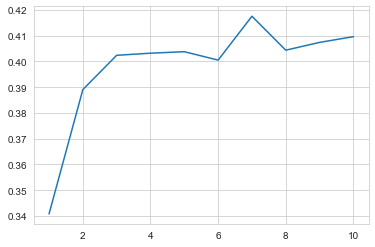

In [21]:
pd.DataFrame(accuracies, columns=['correct', 'wrong', 'average'], index=list(range(1, len(accuracies) + 1))).average.plot();

In [23]:
best_model = Word2Vec.load((gensim_path / 'word2vec_06.model').as_posix())

In [24]:
# gensim computes accuracy based on source text files
detailed_accuracy = best_model.wv.accuracy(analogy_path.as_posix(), case_insensitive=True)

In [25]:
# get accuracy per category
summary = accuracy_by_category(detailed_accuracy)
print('Base Accuracy: Correct {:,.0f} | Wrong {:,.0f} | Avg {:,.2%}\n'.format(*summary))

                       category  correct  incorrect  average
0      capital-common-countries      356         64     0.85
1                 capital-world      911        279     0.77
10  gram6-nationality-adjective      767        289     0.73
14                        total     3582       4998     0.42
7             gram3-comparative      344        526     0.40
4                        family       41         69     0.37
11             gram7-past-tense      351        771     0.31
12                 gram8-plural       86        220     0.28
2                 city-in-state      372        984     0.27
8             gram4-superlative       71        201     0.26
3                      currency       32         96     0.25
9      gram5-present-participle      125        475     0.21
13           gram9-plural-verbs       72        434     0.14
5     gram1-adjective-to-adverb       40        422     0.09
6                gram2-opposite       14        168     0.08
Base Accuracy: Correct 3

In [115]:
results = [[c['section'], len(c['correct']), len(c['incorrect'])] for c in detailed_accuracy]
results = pd.DataFrame(results, columns=['category', 'correct', 'incorrect'])
results['category'] = results.category.map(cat_dict)
results['average'] = results.correct.div(results[['correct', 'incorrect']].sum(1))
results = results.rename(columns=str.capitalize).set_index('Category')
total = results.loc['Total']
results = results.drop('Total')

In [26]:
most_sim = best_model.wv.most_similar(positive=['woman', 'king'], negative=['man'], topn=20)
pd.DataFrame(most_sim, columns=['token', 'similarity'])

,token,similarity
0,lewis,0.36
1,monarch,0.36
2,queen,0.35
3,kate,0.34
4,william,0.34
5,prince,0.34
6,son,0.34
7,james,0.34
8,street,0.33
9,paul,0.33


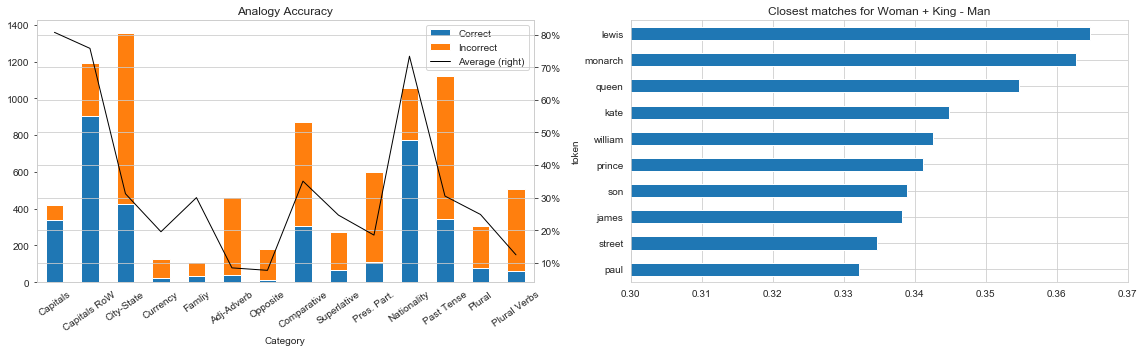

In [126]:
fig, axes = plt.subplots(figsize=(16, 5), ncols=2)

axes[0] = results.loc[:, ['Correct', 'Incorrect']].plot.bar(stacked=True, ax=axes[0]
                                                           , title='Analogy Accuracy')
ax1 = results.loc[:, ['Average']].plot(ax=axes[0], secondary_y=True, lw=1, c='k', rot=35)
ax1.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

(pd.DataFrame(most_sim, columns=['token', 'similarity'])
 .set_index('token').similarity
 .sort_values().tail(10).plot.barh(xlim=(.3, .37), ax=axes[1], title='Closest matches for Woman + King - Man'))
fig.tight_layout()
fig.savefig('figures/w2v_evaluation', dpi=300);

In [14]:
counter = Counter(sentence_path.read_text().split())

In [15]:
most_common = pd.DataFrame(counter.most_common(), columns=['token', 'count'])
most_common = most_common[most_common['count']> MIN_FREQ]
most_common['p'] = np.log(most_common['count'])/np.log(most_common['count']).sum()

In [63]:
similars = pd.DataFrame()
for token in np.random.choice(most_common.token, size=10, p=most_common.p):
    similars[token] = [s[0] for s in best_model.wv.most_similar(token)]
similars.T

,0,1,2,3,4,5,6,7,8,9
profiles,profile,users,political_consultancy_cambridge_analytica,sophisticated,facebook,safety_tolerability,authentic,uncover,tailored,advertisers
divestments,divestitures,acquisitions,takeovers,bayer,consolidation,disposals,acquisitions_divestitures,divestment,linde,joint_ventures
readiness,training,military,command,air_force,preparations,militaries,defense,marine_corps,missiles,combat
arsenal,nuclear_weapons,russia,ballistic_missile,weapons,hezbollah,pyongyang,missiles,missile,nuclear_missile,nuclear_arsenal
supply_disruptions,disruptions,raw_material,disruption,prices,downturn,glut,volatility,oversupply,geopolitical,declines
ethics,integrity,ethical,governance,epa,corporate_governance,principles,watchdog,violated,audit,pruitt
german_carmakers,carmakers,automakers,volkswagen,diesel_vehicles,cars,self_driving_cars,carmaker,daimler,tariffs,vw
averted,avert,strikes,unions,victoria_bryan,possible,walkouts,dent,strike,imminent,paul_carrel
regulated,utility,euronext_paris,utilities,cannabis,regulate,bdc,stringent,regulates,unregulated,electricity
ltd,inc,corp,holdings,brief,llc,view_original_content,group,subsidiary,corporation,mln


In [127]:
similars.T.iloc[:5, :5].to_csv('figures/most_similar.csv')

## Resources

- [Distributed representations of words and phrases and their compositionality](http://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf)
- [Efficient estimation of word representations in vector space](https://arxiv.org/pdf/1301.3781.pdf?)
- [Sebastian Ruder's Blog](http://ruder.io/word-embeddings-1/)